In [1]:
import numpy as np
import yt
import cPickle
from comparative_analysis import *
import builtins
from yt.analysis_modules.level_sets.api import *
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd

comparative_analysis.py:13: VisibleDeprecationWarning: The star_analysis module has been deprecated. This code has been moved to the yt attic (https://bitbucket.org/yt_analysis/yt_attic) and will be removed in a future release.
  from yt.analysis_modules.star_analysis.api import StarFormationRate
/Users/dalek/anaconda2/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [2]:
def get_refine_box(ds, zsnap, track):
    ## find closest output, modulo not updating before printout
    diff = track['col1'] - zsnap
    this_loc = track[np.where(diff == np.min(diff[np.where(diff > 1.e-6)]))]
    print "using this loc:", this_loc
    x_left = this_loc['col2'][0]
    y_left = this_loc['col3'][0]
    z_left = this_loc['col4'][0]
    x_right = this_loc['col5'][0]
    y_right = this_loc['col6'][0]
    z_right = this_loc['col7'][0]
    refine_box_center = [0.5*(x_left+x_right), 0.5*(y_left+y_right), 0.5*(z_left+z_right)]
    refine_box = ds.r[x_left:x_right, y_left:y_right, z_left:z_right]
    refine_width = np.abs(x_right - x_left)
    return refine_box, refine_box_center, refine_width

In [3]:
base = "/Users/dalek/data/Molly/natural/nref11"
fn = base+"/RD0020/RD0020"
track_name = base+"/halo_track"
args = fn.split('/')

ds = yt.load(fn)
track = Table.read(track_name, format='ascii')
track.sort('col1')
rb,rb_center,rb_width = get_refine_box(ds,ds.current_redshift,track)
redshift = ds.current_redshift

box_width = ds.arr(rb_width,'code_length').in_units('kpc')
rb_width = ds.quan(rb_width,'code_length').in_units('kpc')
rb_width = float(rb_width.value)

yt : [INFO     ] 2018-03-01 13:53:22,540 Parameters: current_time              = 154.801187733
yt : [INFO     ] 2018-03-01 13:53:22,541 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-03-01 13:53:22,542 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-03-01 13:53:22,543 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2018-03-01 13:53:22,545 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-03-01 13:53:22,546 Parameters: current_redshift          = 1.99999762534
yt : [INFO     ] 2018-03-01 13:53:22,547 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2018-03-01 13:53:22,548 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2018-03-01 13:53:22,549 Parameters: hubble_constant           = 0.695


using this loc:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.99999996364 0.493032 0.487924 0.501169 0.495032 0.489924 0.503169   10


### Let's set some basic guidelines for what kind of clumps we want to find.

These are example keywords but let's say a clump has to have at least 5 cells. And let's save the total number of cells for the clump.

In [4]:
master_clump = Clump(rb, ("gas", "H_number_density"))
master_clump.add_validator("min_cells", 5)
master_clump.add_info_item("total_cells")

Parsing Hierarchy : 100%|██████████| 1449/1449 [00:00<00:00, 8133.96it/s]
yt : [INFO     ] 2018-03-01 13:53:25,295 Gathering a field list (this may take a moment.)


#### The clump will search HI number density from the minimum to the maximum. I'm still working on playing around with these values. These are just the default from the yt pages.

In [5]:
c_min = rb["gas", "H_number_density"].min()
c_max = rb["gas", "H_number_density"].max()
step = 2.0
find_clumps(master_clump, c_min, c_max, step)

yt : [INFO     ] 2018-03-01 13:53:27,637 Finding clumps: min: 1.440272e-15, max: 1.473033e+03, step: 2.000000
yt : [INFO     ] 2018-03-01 13:53:28,058 Linking node (454) contours.
yt : [INFO     ] 2018-03-01 13:53:29,604 Linked.
Updating joins ... : 100%|██████████| 454/454 [00:00<00:00, 9191.20it/s]
yt : [INFO     ] 2018-03-01 13:53:29,744 Finding clumps: min: 2.880545e-15, max: 1.473033e+03, step: 2.000000
yt : [INFO     ] 2018-03-01 13:53:29,745 Wiping out existing children clumps: 1.
yt : [INFO     ] 2018-03-01 13:53:30,011 Linking node (454) contours.
yt : [INFO     ] 2018-03-01 13:53:31,522 Linked.
Updating joins ... : 100%|██████████| 454/454 [00:00<00:00, 8722.72it/s]
yt : [INFO     ] 2018-03-01 13:53:31,653 Finding clumps: min: 5.761089e-15, max: 1.473033e+03, step: 2.000000
yt : [INFO     ] 2018-03-01 13:53:31,655 Wiping out existing children clumps: 1.
yt : [INFO     ] 2018-03-01 13:53:31,925 Linking node (454) contours.
yt : [INFO     ] 2018-03-01 13:53:33,504 Linked.
Updat

In [6]:
leaf_clumps = get_lowest_clumps(master_clump)
print len(leaf_clumps)

64


yt : [INFO     ] 2018-03-01 14:12:13,018 Projection completed
yt : [INFO     ] 2018-03-01 14:12:13,019 xlim = 0.487924 0.489924
yt : [INFO     ] 2018-03-01 14:12:13,019 ylim = 0.501169 0.503169
yt : [INFO     ] 2018-03-01 14:12:13,021 xlim = 0.487924 0.489924
yt : [INFO     ] 2018-03-01 14:12:13,022 ylim = 0.501169 0.503169
yt : [INFO     ] 2018-03-01 14:12:13,025 Making a fixed resolution buffer of (('gas', 'H_number_density')) 800 by 800
yt : [INFO     ] 2018-03-01 14:12:13,618 Pixelizing contour 0
yt : [INFO     ] 2018-03-01 14:12:13,710 Pixelizing contour 1
yt : [INFO     ] 2018-03-01 14:12:13,718 Pixelizing contour 2
yt : [INFO     ] 2018-03-01 14:12:13,724 Pixelizing contour 3
yt : [INFO     ] 2018-03-01 14:12:13,730 Pixelizing contour 4
yt : [INFO     ] 2018-03-01 14:12:13,740 Pixelizing contour 5
yt : [INFO     ] 2018-03-01 14:12:13,748 Pixelizing contour 6
yt : [INFO     ] 2018-03-01 14:12:13,757 Pixelizing contour 7
yt : [INFO     ] 2018-03-01 14:12:13,766 Pixelizing contour 


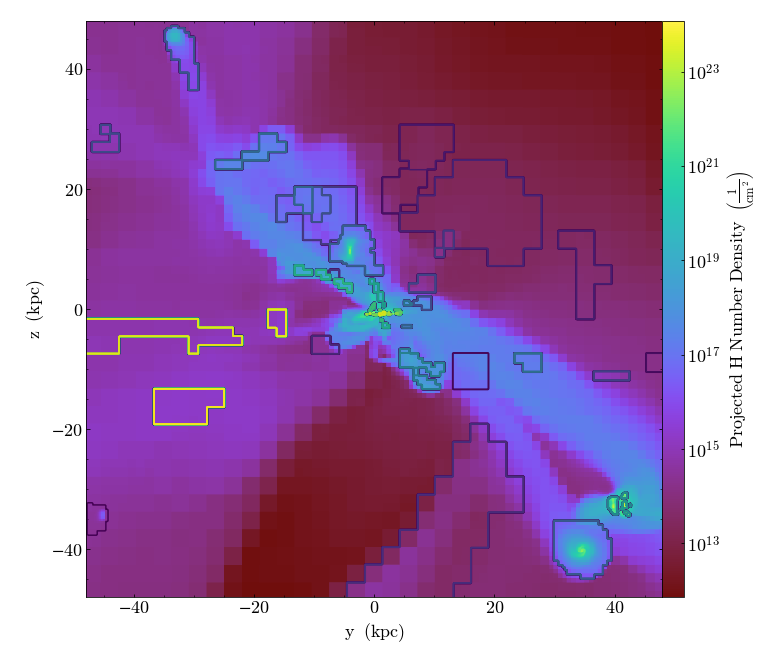

In [7]:
prj = yt.ProjectionPlot(ds,'x',"H_number_density",center=rb_center, width=(rb_width,'kpc'),data_source=rb)
prj.annotate_clumps(leaf_clumps)
#prj.save('clumps')
prj.show()

yt : [INFO     ] 2018-03-01 14:12:21,351 xlim = 0.487924 0.489924
yt : [INFO     ] 2018-03-01 14:12:21,352 ylim = 0.501169 0.503169
yt : [INFO     ] 2018-03-01 14:12:21,354 xlim = 0.487924 0.489924
yt : [INFO     ] 2018-03-01 14:12:21,355 ylim = 0.501169 0.503169
yt : [INFO     ] 2018-03-01 14:12:21,357 Making a fixed resolution buffer of (('gas', 'H_number_density')) 800 by 800
yt : [INFO     ] 2018-03-01 14:12:21,731 Pixelizing contour 0
yt : [INFO     ] 2018-03-01 14:12:21,738 Pixelizing contour 1
yt : [INFO     ] 2018-03-01 14:12:21,740 Pixelizing contour 2
yt : [INFO     ] 2018-03-01 14:12:21,742 Pixelizing contour 3
yt : [INFO     ] 2018-03-01 14:12:21,745 Pixelizing contour 4
yt : [INFO     ] 2018-03-01 14:12:21,749 Pixelizing contour 5
yt : [INFO     ] 2018-03-01 14:12:21,752 Pixelizing contour 6
yt : [INFO     ] 2018-03-01 14:12:21,756 Pixelizing contour 7
yt : [INFO     ] 2018-03-01 14:12:21,760 Pixelizing contour 8
yt : [INFO     ] 2018-03-01 14:12:21,763 Pixelizing contour 


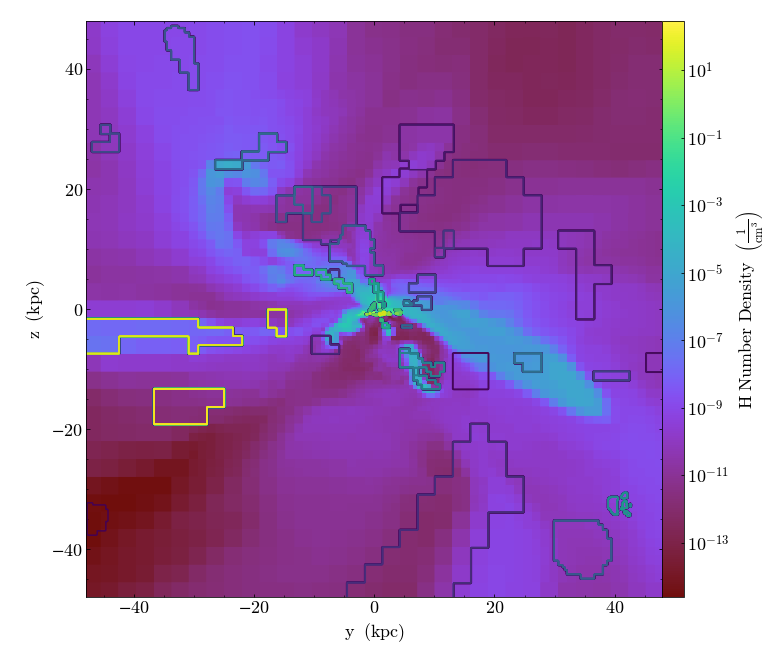

In [8]:
prj = yt.SlicePlot(ds,'x',"H_number_density",center=rb_center, width=(rb_width,'kpc'),data_source=rb)
prj.annotate_clumps(leaf_clumps)
#prj.save('clumps')
prj.show()

#### Looking by eye, it seems like using the following values would be good for identifying the filaments. 

In [9]:
c_min = 1e-7
c_max = 1e-5
step = 2.0
find_clumps(master_clump, c_min, c_max, step)

leaf_clumps = get_lowest_clumps(master_clump)

yt : [INFO     ] 2018-03-01 14:12:27,745 Finding clumps: min: 1.000000e-07, max: 1.000000e-05, step: 2.000000
yt : [INFO     ] 2018-03-01 14:12:27,748 Wiping out existing children clumps: 2.
yt : [INFO     ] 2018-03-01 14:12:27,992 Linking node (454) contours.
yt : [INFO     ] 2018-03-01 14:12:29,563 Linked.
Updating joins ... : 100%|██████████| 454/454 [00:00<00:00, 26716.81it/s]
yt : [INFO     ] 2018-03-01 14:12:29,697 Investigating 8 children.
yt : [INFO     ] 2018-03-01 14:12:29,698 Finding clumps: min: 2.000000e-07, max: 1.000000e-05, step: 2.000000
yt : [INFO     ] 2018-03-01 14:12:30,152 Linking node (332) contours.
yt : [INFO     ] 2018-03-01 14:12:31,222 Linked.
Updating joins ... : 100%|██████████| 332/332 [00:00<00:00, 18507.07it/s]
yt : [INFO     ] 2018-03-01 14:12:31,359 Investigating 2 children.
yt : [INFO     ] 2018-03-01 14:12:31,359 Finding clumps: min: 4.000000e-07, max: 1.000000e-05, step: 2.000000
yt : [INFO     ] 2018-03-01 14:12:31,863 Linking node (332) contours.

#### and it is!

yt : [INFO     ] 2018-03-01 14:13:43,638 Projection completed
yt : [INFO     ] 2018-03-01 14:13:43,639 xlim = 0.487924 0.489924
yt : [INFO     ] 2018-03-01 14:13:43,640 ylim = 0.501169 0.503169
yt : [INFO     ] 2018-03-01 14:13:43,642 xlim = 0.487924 0.489924
yt : [INFO     ] 2018-03-01 14:13:43,643 ylim = 0.501169 0.503169
yt : [INFO     ] 2018-03-01 14:13:43,646 Making a fixed resolution buffer of (('gas', 'H_number_density')) 800 by 800
yt : [INFO     ] 2018-03-01 14:13:44,000 Pixelizing contour 0
yt : [INFO     ] 2018-03-01 14:13:44,008 Pixelizing contour 1
yt : [INFO     ] 2018-03-01 14:13:44,014 Pixelizing contour 2
yt : [INFO     ] 2018-03-01 14:13:44,020 Pixelizing contour 3
yt : [INFO     ] 2018-03-01 14:13:44,028 Pixelizing contour 4
yt : [INFO     ] 2018-03-01 14:13:44,049 Pixelizing contour 5
yt : [INFO     ] 2018-03-01 14:13:44,055 Pixelizing contour 6
yt : [INFO     ] 2018-03-01 14:13:44,059 Pixelizing contour 7
yt : [INFO     ] 2018-03-01 14:13:44,074 Pixelizing contour 


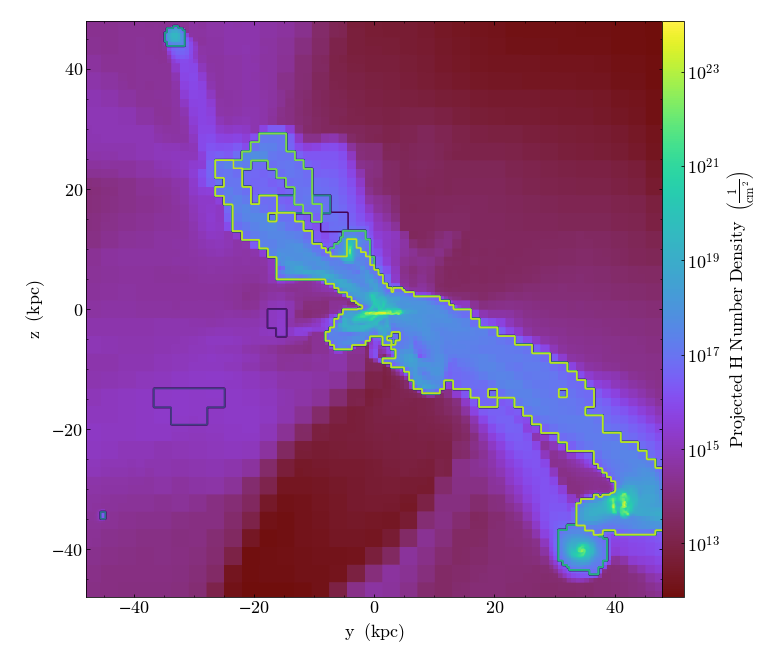

In [10]:
prj = yt.ProjectionPlot(ds,'x',"H_number_density",center=rb_center, width=(rb_width,'kpc'),data_source=rb)
prj.annotate_clumps(leaf_clumps)
#prj.save('clumps')
prj.show()